In [48]:
import gym
from gym import wrappers
from gym.spaces.utils import flatdim
import torch as pt
import cv2

import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm

import io
import base64
from IPython.display import HTML

# Comment out for debugging
import warnings
warnings.filterwarnings('ignore')

In [49]:
def play_video(ep_number: int):
    video = io.open(f"./gym-results/rl-video-episode-{ep_number}.mp4", 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''
        <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
    .format(encoded.decode('ascii')))

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

100%|██████████| 1000/1000 [00:01<00:00, 935.42it/s]


Text(0.5, 1.0, 'Rewards over 2 episodes')

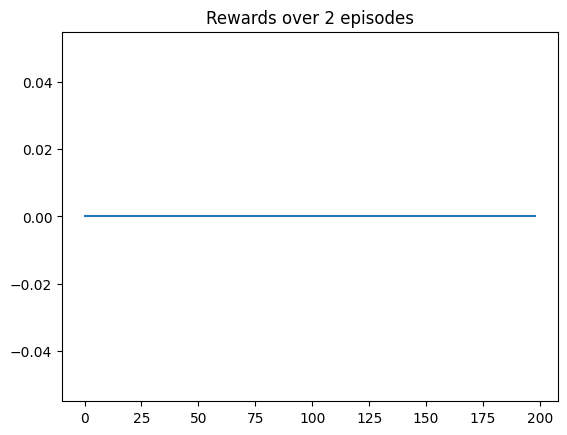

In [50]:
env = gym.make("ALE/Pong-v5")
env = wrappers.RecordVideo(env, "./gym-results", new_step_api=True)
env.reset(seed=42)

# hyperparams
num_steps = 1000
random_rewards = [0]
random_lengths = [0]
ep_len = 0
for _ in trange(num_steps):
   action = env.action_space.sample() 
   observation, reward, done, info, _ = env.step(action)

   if done:
      random_rewards.append(reward)
      random_lengths.append(ep_len)
      observation = env.reset()
      ep_len = 0
   
   ep_len += 1
env.close()

plt.plot(smooth(random_rewards, 200))
plt.title(f"Rewards over {len(random_rewards)} episodes")

In [51]:
import collections
# Several useful wrapper environments
class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3
    
    def step(self, action):
        return self.env.step(action)
       
def reset(self):
    self.env.reset()
    obs, _, done, _ = self.env.step(1)
    if done:
        self.env.reset()
    obs, _, done, _ = self.env.step(2)
    if done:
        self.env.reset()
    return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip
        
    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
           obs, reward, done, info, _ = self.env.step(action)
           self._obs_buffer.append(obs)
           total_reward += reward
           if done:
               break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info, _

    def reset(self):
       self._obs_buffer.clear()
       obs = self.env.reset()
       self._obs_buffer.append(obs)
       return obs

# TODO: Still produces broken ball and split user paddle
class ProcessFrame84(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, 
                            shape=(84, 84, 1), dtype=np.uint8)
    
    def observation(self, obs):
        return ProcessFrame84.process(obs)
         
    @staticmethod
    def process(frame):
        if frame.size == 210 * 160 * 3:
            img = np.reshape(frame, [210, 160,  3]).astype(np.float32)
        elif frame.size == 250 * 160 * 3:
            img = np.reshape(frame, [250, 160, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution." 

        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110),            
                        interpolation=cv2.INTER_AREA)
        x_t = resized_screen[16:100, :] # remove scoreboard + bottom
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)

class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0,            
                                shape=(old_shape[-1], 
                                old_shape[0], old_shape[1]),
                                dtype=np.float32)
    def observation(self, observation):
      return np.moveaxis(observation, 2, 0)

# Stacks several frames together
class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = \
                 gym.spaces.Box(old_space.low.repeat(n_steps, 
                 axis=0),old_space.high.repeat(n_steps, axis=0),     
                 dtype=dtype)
    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low,
        dtype=self.dtype)
        return self.observation(self.env.reset())
        
    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer

class ScaledFloatFrame(gym.ObservationWrapper):
     def observation(self, obs):
         return np.array(obs).astype(np.float32) / 255.0

def make_pong():
   env = gym.make("ALE/Pong-v5")
   env = wrappers.RecordVideo(env, "./gym-results", new_step_api=True)
   env = MaxAndSkipEnv(env)
   env = FireResetEnv(env)
   env = ProcessFrame84(env)
   env = ImageToPyTorch(env)
   env = BufferWrapper(env, 4)
   env = ScaledFloatFrame(env)

   return env



In [80]:
import torch.nn as nn

class QNet(nn.Module):
    def __init__(self, obs_space, act_space):
        super(QNet, self).__init__()
        self.obs_shape = obs_space.low.shape
        self.act_shape = flatdim(act_space)
        self.replay_memory = []

        self.conv1 = nn.Conv2d(self.obs_shape[0], 16, 8, stride=4)
        self.conv2 = nn.Conv2d(16, 32, 4, stride=2)
        self.fc1 = nn.Linear(2592, 256) # mathemagic
        self.out = nn.Linear(256, self.act_shape)

        self.optimizer = pt.optim.Adam(self.parameters())
        self.loss = nn.HuberLoss()
    
    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        return self.out(x)





In [96]:
def epsilon_greedy(q_vals, epsilon=0.1):
    if pt.rand(1) < 0:
        return pt.rand_like(q_vals)
    
    return pt.argmax(q_vals)

class ReplayMemory():
    def __init__(self, size, obs_space, act_shape):
        self.size = size
        self.counter = 0

        obs_shape = obs_space.shape

        self.obs = np.zeros((size, *obs_shape))
        self.actions = np.zeros((size))
        self.rewards = np.zeros((size))
        self.obs_n = np.zeros((size, *obs_shape))
        self.done = np.zeros((size))
    
    def store_transition(self, obs, action, obs_n, r, done):
        indx = self.counter % self.size

        self.obs[indx] = obs
        self.actions[indx] = action
        self.rewards[indx] = r
        self.obs_n[indx] = obs_n
        self.done[indx] = done

        self.counter += 1
    
    def sample_batch(self, batch_size):
        max_mem = min(self.counter, self.size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        obs = pt.from_numpy(self.obs[batch]).float()
        actions = pt.from_numpy(self.actions[batch]).long()
        rewards = pt.from_numpy(self.rewards[batch]).float()
        obs_n = pt.from_numpy(self.obs_n[batch]).float()
        terminal = pt.from_numpy(self.done[batch]).bool()

        return obs, actions, rewards, obs_n, terminal



In [97]:

# Test
env = make_pong()
obs = env.reset()
memory = ReplayMemory(10, env.observation_space, env.action_space)

dqn = QNet(env.observation_space, env.action_space)
print(dqn)
obs_n, r, done, _, _ = env.step(env.action_space.sample())

# q_vals = dqn(pt.tensor(obs))
# action = epsilon_greedy(q_vals)
action = 0

print(f"Storing transition: {obs.shape}, {action}, {obs_n.shape}, {r}, {done}")
memory.store_transition(obs, action, obs_n, r, done)
memory.store_transition(obs, action, obs_n, r, done)
memory.store_transition(obs, action, obs_n, r, done)
memory.store_transition(obs, action, obs_n, r, done)
memory.store_transition(obs, action, obs_n, r, done)
memory.store_transition(obs, action, obs_n, r, done)
states, actions, rewards, states_, dones = memory.sample_batch(6)
print(f"Transition: {rewards}")
q_vals = dqn(states)
print(f"All q-vals: {q_vals}")

QNet(
  (conv1): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (fc1): Linear(in_features=2592, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=6, bias=True)
  (loss): HuberLoss()
)
Storing transition: (4, 84, 84), 0, (4, 84, 84), 0.0, False
Transition: tensor([0., 0., 0., 0., 0., 0.])
All q-vals: tensor([[ 0.0589, -0.0327, -0.0576,  0.0552, -0.0230, -0.0022],
        [ 0.0589, -0.0327, -0.0576,  0.0552, -0.0230, -0.0022],
        [ 0.0589, -0.0327, -0.0576,  0.0552, -0.0230, -0.0022],
        [ 0.0589, -0.0327, -0.0576,  0.0552, -0.0230, -0.0022],
        [ 0.0589, -0.0327, -0.0576,  0.0552, -0.0230, -0.0022],
        [ 0.0589, -0.0327, -0.0576,  0.0552, -0.0230, -0.0022]],
       grad_fn=<AddmmBackward0>)


In [100]:
# Pseudocode from DQN Paper
env = make_pong()

# Hyperparams
epsilon = 0.1
batch_size = 1000
update_freq = 100
gamma = 0.99

# Initialize Replay Memory to capacity N
replay_capacity = 1000
memory = ReplayMemory(replay_capacity, env.observation_space, env.action_space)

# Initialize action-value Function Q with random weights
Q = QNet(env.observation_space, env.action_space)
T = QNet(env.observation_space, env.action_space)

num_episodes = batch_size + 1
pbar = tqdm(range(num_episodes))
i = 0
for ep in pbar:
    obs = env.reset()
    done = False
    while not done:

        # Select action random action with prob epsilon, otherwise argmax_a Q(obs, a)
        action = epsilon_greedy(Q(pt.from_numpy(obs).unsqueeze(0).float()))

        r, obs_n, done, _, _ = env.step(action)

        memory.store_transition(obs, action, r, obs_n, done)

        cur_loss = 0
        if (memory.counter > batch_size):
            # Update network weights on batch
            Q.optimizer.zero_grad()

            states, actions, rewards, states_, dones = memory.sample_batch(batch_size)
            indices = np.arange(batch_size)

            q_pred = Q.forward(states)[indices, actions]
            q_next = T.forward(states_).max(dim=1)[0]

            q_next[dones] = 0.0
            q_target = rewards + gamma*q_next

            loss = Q.loss(q_target, q_pred)
            loss.backward()
            Q.optimizer.step()
        
        pbar.set_description(f"Current Loss: {loss}")
        if i % update_freq == 0:
            T.load_state_dict(Q.state_dict())

Current Loss: 0.05440390855073929:   0%|          | 5/1001 [00:05<16:10,  1.03it/s]

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.06196628510951996:   0%|          | 5/1001 [00:06<16:10,  1.03it/s]

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.04936188831925392:   0%|          | 5/1001 [00:06<16:10,  1.03it/s]

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.05004259571433067:   0%|          | 5/1001 [00:07<16:10,  1.03it/s]

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.05203894525766373:   0%|          | 5/1001 [00:07<16:10,  1.03it/s]

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.05167233198881149:   0%|          | 5/1001 [00:08<16:10,  1.03it/s]

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.0512743815779686:   0%|          | 5/1001 [00:08<16:10,  1.03it/s] 

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.05062419921159744:   0%|          | 5/1001 [00:09<16:10,  1.03it/s]

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.049205705523490906:   0%|          | 5/1001 [00:09<16:10,  1.03it/s]

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.048571862280368805:   0%|          | 5/1001 [00:10<16:10,  1.03it/s]

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.04977418854832649:   0%|          | 5/1001 [00:10<16:10,  1.03it/s] 

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.050075408071279526:   0%|          | 5/1001 [00:11<16:10,  1.03it/s]

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.049538228660821915:   0%|          | 5/1001 [00:11<16:10,  1.03it/s]

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.049068618565797806:   0%|          | 5/1001 [00:12<16:10,  1.03it/s]

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.049027830362319946:   0%|          | 5/1001 [00:12<16:10,  1.03it/s]

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.04883544147014618:   0%|          | 5/1001 [00:13<16:10,  1.03it/s] 

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.049048393964767456:   0%|          | 5/1001 [00:13<16:10,  1.03it/s]

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.04914326220750809:   0%|          | 5/1001 [00:13<16:10,  1.03it/s] 

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.04910237342119217:   0%|          | 5/1001 [00:14<16:10,  1.03it/s]

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.0493633896112442:   0%|          | 5/1001 [00:15<16:10,  1.03it/s] 

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.04914088174700737:   0%|          | 5/1001 [00:15<16:10,  1.03it/s]

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.049090031534433365:   0%|          | 5/1001 [00:16<16:10,  1.03it/s]

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.04917954280972481:   0%|          | 5/1001 [00:16<16:10,  1.03it/s] 

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.049308452755212784:   0%|          | 5/1001 [00:17<16:10,  1.03it/s]

States shape: torch.Size([1000, 4, 84, 84]), torch.Size([1000, 4, 84, 84])


Current Loss: 0.049308452755212784:   0%|          | 5/1001 [00:17<58:48,  3.54s/it]


KeyboardInterrupt: 